In [ ]:
import warnings
warnings.filterwarnings("ignore")

from pprint import pprint

import json

import os

from unsloth import FastLanguageModel
import torch

from multiprocessing import cpu_count
num_proc = cpu_count()

import yaml

from data_processor import SplittedJsonIoDataset
from customs import customize_tokenizer

from unsloth import UnslothTrainer, UnslothTrainingArguments

from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from transformers import TrainingArguments, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling
from unsloth import is_bfloat16_supported

from unsloth.chat_templates import train_on_responses_only

from unsloth import unsloth_train

from utils import save_log_history

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [2]:
from unsloth import PatchDPOTrainer

PatchDPOTrainer()

In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "/mnt/data/training-outputs/Llama-3.1-8B-Malware-Expert/checkpoint-271",
    fast_inference = False,
    load_in_4bit = True,
    max_seq_length = None,
    gpu_memory_utilization = 0.8
)

==((====))==  Unsloth 2025.6.8: Fast Llama patching. Transformers: 4.53.0. vLLM: 0.9.1.
   \\   /|    NVIDIA H100 PCIe. Num GPUs = 1. Max memory: 79.179 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.0+cu126. CUDA: 9.0. CUDA Toolkit: 12.6. Triton: 3.3.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.30. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth 2025.6.8 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [4]:
for name, param in model.named_parameters():
    if name in ["base_model.model.lm_head.modules_to_save.default.weight", "base_model.model.model.embed_tokens.modules_to_save.default.weight"]:
        param.requires_grad = True

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 1134559232


In [5]:
import pandas as pd

train_data = pd.read_csv("malware_train_data_for_DPO.csv")
eval_data = pd.read_csv("malware_eval_data_for_DPO.csv")

In [6]:
train_data["input_lengths"] = train_data.prompt.apply(lambda x:len(x))
eval_data["input_lengths"] = eval_data.prompt.apply(lambda x:len(x))
train_data["input_lengths"].describe()

count      1381.000000
mean      38388.869660
std       25055.565342
min        6221.000000
25%       21026.000000
50%       33097.000000
75%       49372.000000
max      359614.000000
Name: input_lengths, dtype: float64

In [7]:
threshold = 30000

train_data = train_data[train_data.input_lengths<threshold].drop(columns=["input_lengths"])
eval_data = eval_data[eval_data.input_lengths<threshold].drop(columns=["input_lengths"])


train_data.chosen = train_data.chosen.str.replace("<|eot_id|>", "")
train_data.rejected = train_data.rejected.str.replace("<|eot_id|>", "")

eval_data.chosen = eval_data.chosen.str.replace("<|eot_id|>", "")
eval_data.rejected = eval_data.rejected.str.replace("<|eot_id|>", "")

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 626 entries, 0 to 1380
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prompt    626 non-null    object
 1   chosen    626 non-null    object
 2   rejected  626 non-null    object
dtypes: object(3)
memory usage: 19.6+ KB


In [9]:
eval_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 101 entries, 0 to 219
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   prompt    101 non-null    object
 1   chosen    101 non-null    object
 2   rejected  101 non-null    object
dtypes: object(3)
memory usage: 3.2+ KB


In [10]:
import datasets 

dataset = datasets.DatasetDict(
    {
        "train":datasets.Dataset.from_pandas(train_data),
        "eval":datasets.Dataset.from_pandas(eval_data)
    }
)

In [11]:
from trl import DPOTrainer, DPOConfig

dpo_trainer = DPOTrainer(
    model = model,
    ref_model = None,
    args = DPOConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_ratio = 0.1,
        num_train_epochs = 3,
        learning_rate = 1e-6,
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.0,
        lr_scheduler_type = "cosine",
        seed = 4231,
        output_dir = "Llama-3.1-8B-Instruct-DPO-Malware-Expert",
        report_to = "tensorboard",
        fp16_full_eval = True,
        per_device_eval_batch_size = 1,
        eval_accumulation_steps = 2,
        eval_strategy = "steps",
        logging_strategy = "steps",
        save_strategy = "best",
        metric_for_best_model = "loss",
        save_total_limit = 1,
        load_best_model_at_end= True,
        max_length = 50000,
        max_prompt_length = 50000,
    ),
    beta = 0.1,
    train_dataset = dataset["train"],
    eval_dataset = dataset["eval"],
    tokenizer = tokenizer,
)

Extracting prompt in train dataset (num_proc=30):   0%|          | 0/626 [00:00<?, ? examples/s]

Applying chat template to train dataset (num_proc=30):   0%|          | 0/626 [00:00<?, ? examples/s]

Tokenizing train dataset (num_proc=30):   0%|          | 0/626 [00:00<?, ? examples/s]

Extracting prompt in eval dataset (num_proc=30):   0%|          | 0/101 [00:00<?, ? examples/s]

Applying chat template to eval dataset (num_proc=30):   0%|          | 0/101 [00:00<?, ? examples/s]

Tokenizing eval dataset (num_proc=30):   0%|          | 0/101 [00:00<?, ? examples/s]

In [12]:
# Start training
trainer_stats = unsloth_train(dpo_trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 626 | Num Epochs = 3 | Total steps = 939
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 2 x 1) = 2
 "-____-"     Trainable parameters = 1,134,559,232/8,000,000,000 (14.18% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss,rewards / chosen,rewards / rejected,rewards / accuracies,rewards / margins,logps / chosen,logps / rejected,logits / chosen,logits / rejected,eval_logits / chosen,eval_logits / rejected,nll_loss,aux_loss
1,0.181100,0.194875,3.050807,1.050599,0.990099,2.000209,-1.194070,-93.908272,1.422639,1.385550,0,0,0,0
2,0.054600,0.195295,3.050358,1.053735,0.990099,1.996623,-1.198568,-93.876907,1.422759,1.384601,No Log,No Log,No Log,No Log
3,0.728100,0.194973,3.050357,1.046750,0.990099,2.003608,-1.198573,-93.946754,1.420863,1.383568,No Log,No Log,No Log,No Log
4,0.137600,0.195460,3.049778,1.049343,0.990099,2.000435,-1.204364,-93.920822,1.422520,1.385486,No Log,No Log,No Log,No Log
5,0.066900,0.194269,3.049879,1.040464,0.990099,2.009415,-1.203353,-94.009621,1.420678,1.383532,No Log,No Log,No Log,No Log
6,0.226900,0.194086,3.050552,1.042563,0.990099,2.007989,-1.196622,-93.988632,1.421498,1.383726,No Log,No Log,No Log,No Log
7,0.167300,0.191842,3.050990,1.026148,0.990099,2.024842,-1.192242,-94.152771,1.419723,1.382823,No Log,No Log,No Log,No Log
8,0.164800,0.191173,3.051003,1.023661,0.990099,2.027341,-1.192115,-94.177650,1.420701,1.383745,No Log,No Log,No Log,No Log
9,0.134300,0.190072,3.050848,1.013626,0.990099,2.037222,-1.193670,-94.278000,1.418293,1.380884,No Log,No Log,No Log,No Log
10,0.159600,0.189783,3.049925,1.009461,0.990099,2.040464,-1.202894,-94.319649,1.417912,1.381282,No Log,No Log,No Log,No Log


KeyboardInterrupt: 

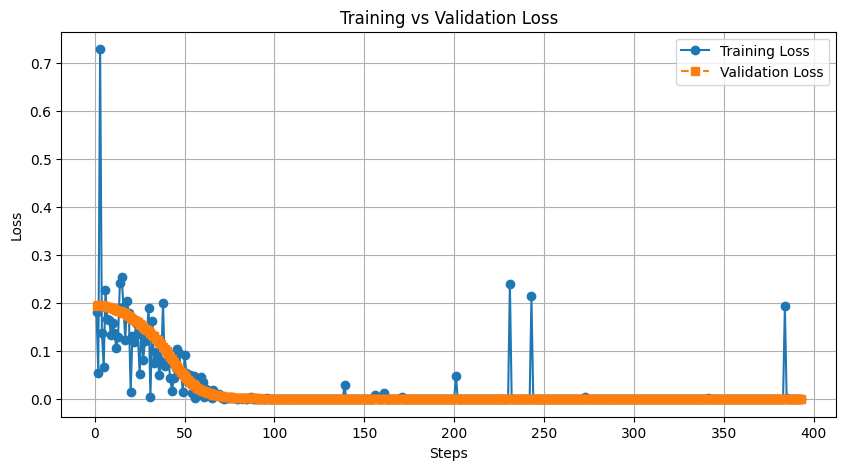

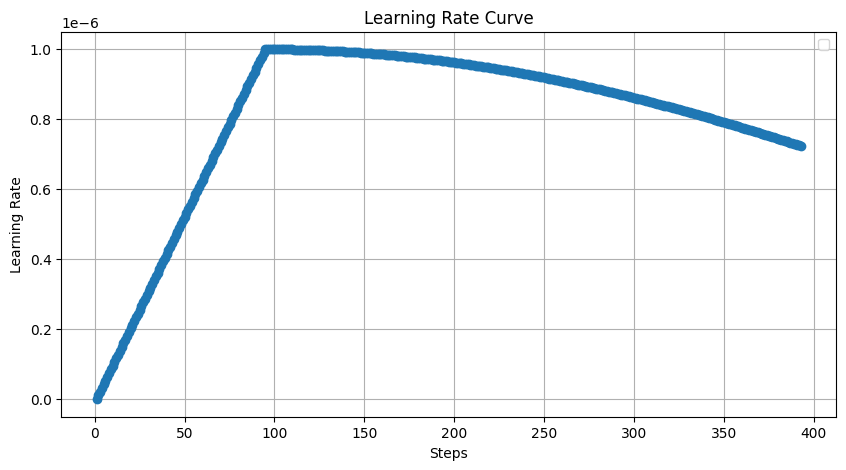

In [13]:
save_log_history(dpo_trainer)